In [1]:
import dgl
import torch
from dgl.data import AIFBDataset, MUTAGDataset, BGSDataset, AMDataset, CoraGraphDataset
from torch.utils.data import IterableDataset, Dataset, DataLoader

In [5]:
import networkx as nx

def draw_graph(dgl_graph):
    nx_G = dgl_graph.to_networkx()
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw_networkx(nx_G, pos, with_labels=True, node_color=[[.5, .5, .5]])

# DGL basic

## 1.1 to_block
Convert a graph into a bipartite-structured block for message passing.

dgl.to_block(g, dst_nodes=None, include_dst_in_src=True, src_nodes=None)

参数说明:

- g: (DGLGraph) – 需要转化成block的图

- dst_nodes--: (Tensor or dict[str, Tensor], optional) – 目标节点列表
If a tensor is given, the graph must have only one node type. If given, it must be a superset of all the nodes that have at least one inbound edge.
An error will be raised otherwise.

- include_dst_in_src (bool): – 如果为 False,

目标节点将不包含源节点，(目标节点往往也是源节点，因为，目标节点的新feature = 目标节点原先feature + aggrevate(周围节点)). (Default: True)

- src_nodes :(Tensor or disct[str, Tensor], optional) – The list of source nodes (and prefixed by destination nodes if include_dst_in_src is True).
If a tensor is given, the graph must have only one node type.

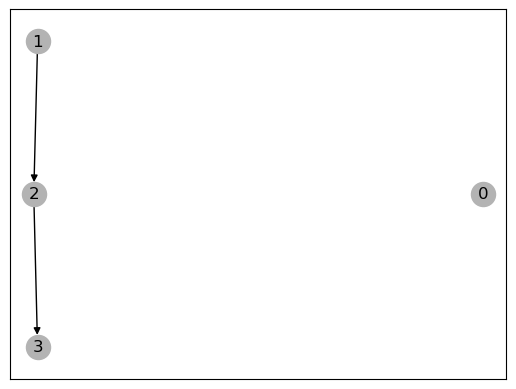

In [6]:
g = dgl.graph(([1, 2], [2, 3]))
draw_graph(g)

### 1.1.1 dgl.NID
二部图的源侧和目标侧这两个type，各自对应的节点编号信息，均存在dgl.NID feature中

In [8]:
block = dgl.to_block(g, torch.LongTensor([3, 2]))

induced_dst = block.dstdata[dgl.NID]
induced_dst

tensor([3, 2])

In [9]:
induced_src = block.srcdata[dgl.NID]
induced_src

tensor([3, 2, 1])

In [10]:
## 边的编号信息，存在dgl.EID feature中
block.edata[dgl.EID]

tensor([0, 1])

In [11]:
dgl.EID

'_ID'

## 1.2 sampling.sample_neighbors
根据给定的节点，采样出子图

`dgl.sampling.sample_neighbors(g, nodes, fanout, edge_dir='in', prob=None, replace=False, copy_ndata=True, copy_edata=True, _dist_training=False, exclude_edges=None, output_device=None)`

参数说明:

- g: dgl图
- nodes: 给定的节点
- fanout: int/dict, 为nodes中的每一个节点，每一个类型的边，采样多少条
- edge_dir: 'in' 入边; 'out' 出边
- exclude_edges: tensor/dict, 采样是需要排除的边

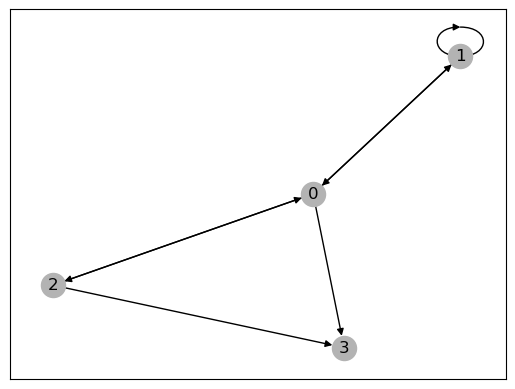

In [12]:

g = dgl.graph(([0, 0, 1, 1, 2, 2,0], [1, 2, 0, 1, 3, 0,3]))
draw_graph(g)

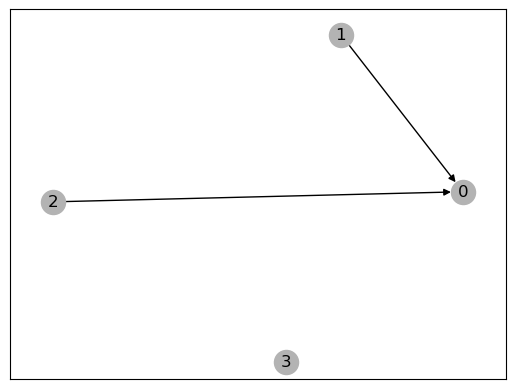

In [14]:
sg = dgl.sampling.sample_neighbors(g, [0], 2)
draw_graph(sg)

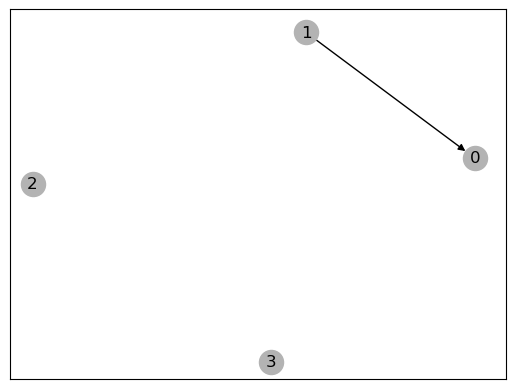

In [15]:
sg = dgl.sampling.sample_neighbors(g, [0], 1)
draw_graph(sg)

## 1.3 利用to_block和sample_negihbors构架graphSAGE的训练集

In [16]:
def build_cora_dataset(add_symmetric_edges=True, add_self_loop=True):
    dataset = CoraGraphDataset()
    graph = dataset[0]

    train_mask = graph.ndata['train_mask']
    val_mask = graph.ndata['val_mask']
    test_mask = graph.ndata['test_mask']
    labels = graph.ndata['label']
    feat = graph.ndata['feat']

    if add_symmetric_edges:
        edges = graph.edges()
        graph.add_edges(edges[1], edges[0])

    graph = dgl.remove_self_loop(graph)
    if add_self_loop:
        graph = dgl.add_self_loop(graph)
    return graph

In [17]:
graph = build_cora_dataset()

Extracting file to /Users/pomelo/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


### 1.3.2 Select NodeSet

In [18]:
class HomoNodesSet(Dataset):
    def __init__(self, g, mask):
        # only load masked node for training/testing
        self.g = g
        self.nodes = g.nodes()[mask].tolist()

    def __len__(self):
        return len(self.nodes)

    def __getitem__(self, index):
        heads = self.nodes[index]
        return heads

In [19]:
train_mask = graph.ndata['train_mask']
batch_sampler = HomoNodesSet(graph, train_mask)
print(graph.nodes()[train_mask].tolist())
print(batch_sampler[1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
1


# Nodes' and Edges' attributes

In [20]:
# Node attributes
graph.ndata.keys()

dict_keys(['train_mask', 'val_mask', 'test_mask', 'label', 'feat'])

In [21]:
train_mask = graph.ndata["train_mask"]
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [22]:
# Edges' attributes
graph.edata.keys()

dict_keys([])

In [23]:
for col, data in graph.edata.items():
    print(col)
    print(data)
    print("=====")

In [24]:
batch_sampler = HomoNodesSet(graph, train_mask)
print("batch_sampler len = ", len(batch_sampler))
print(batch_sampler[2])


batch_sampler len =  140
2


# 3. dgl.sampling.sample_neighbors
Sample neighboring edges of the given nodes and return the induced subgraph.
选取graph中，以某个节点为起点，几度以内的图，可指定是入度边还是出度边
边的原始id将保存在名为dgl.EID的特征中

In [25]:
rontier = dgl.sampling.sample_neighbors(
                graph,
                [2],
                fanout=2,
                edge_dir='in')

In [26]:
rontier

Graph(num_nodes=2708, num_edges=2,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [27]:
rontier.edata[dgl.EID]

tensor([10564,  8132])

# DATASET

In [29]:
frontier = dgl.sampling.sample_neighbors(
                graph,
                2,
                fanout=2,
                edge_dir='in')

In [30]:
frontier

Graph(num_nodes=2708, num_edges=2,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})